In [1]:
#import google colab library so you can connect the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#install the required packages
!pip install gym_super_mario_bros==7.3.0 nes_py
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install torch==1.12.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.12.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip install stable-baselines3[extra]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 198 kB 14.7 MB/s 
     |████████████████████████████████| 77 kB 7.0 MB/s 
     |████████████████████████████████| 1.1 MB 56.0 MB/s 
  Created wheel for nes-py: filename=nes_py-8.2.1-cp37-cp37m-linux_x86_64.whl size=437309 sha256=51d97b5582ba399bf83fbd55a5dc6b972fe50adc942c36f6b276e06ead9e0e89
  Stored in directory: /root/.cache/pip/wheels/17/96/0e/22a8c7dbdf412d8e988286f223b223baf0f4ad90c9e699c56d
Successfully built nes-py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
     |████████████████████████████████| 24.6 MB 1.3 MB/s 
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     |██████████████▌                 | 834.1 MB 1.4 MB/s et

In [3]:
#import the supermario library and the environment library
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
#import the needed libraries such as numpy and matplotlib and the other libraries used for the animation
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

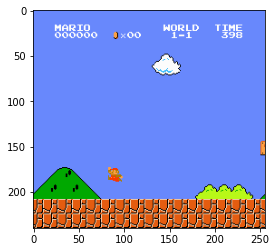

In [4]:
#defines the environment and shows a gif sample of the game environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)
#creates the loop for the display
for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()

In [5]:
#import the libraries used in the wrappers
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt

In [6]:
#environment of the game
env = gym_super_mario_bros.make('SuperMarioBros-v0')
#controls of the environment
env = JoypadSpace(env, SIMPLE_MOVEMENT)
#grayscale
env = GrayScaleObservation(env, keep_dim=True)
#wrap the inputs into the dummy environment
env = DummyVecEnv([lambda: env])
#stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [7]:
state = env.reset()
state, reward, done, info = env.step([5])

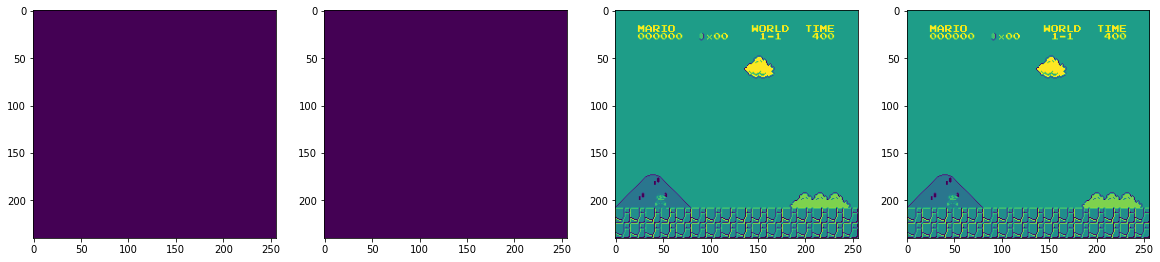

In [8]:
#plot a frame sample of the environment
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

In [9]:
#import libraries used in file management, PPO and callbacks
import os 
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [10]:
#creates the blueprint for the training, saving and model
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [11]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [12]:
#model callback
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [13]:
#start of the AI model
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 
#start of the AI training and learning
model.learn(total_timesteps=10000, callback=callback)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to ./logs/PPO_1


/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 31  |
|    iterations      | 1   |
|    time_elapsed    | 16  |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 2             |
|    time_elapsed         | 24            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 1.2790784e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | -0.00991      |
|    learning_rate        | 1e-06         |
|    loss                 | 127           |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000101     |
|    value_loss           | 381           |
-------------------------------------------
-----

In [14]:
#save the model 
model.save('thisisatestmodel')

In [15]:
#load the model
model = PPO.load('./train/best_model_10000')

In [16]:
#start the game with the AI
state = env.reset()

from gym import wrappers

env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()
for _ in range(4000):
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    if done: break
env.close()

/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


In [18]:
#saves a video copy of the gameplay
import io
import base64
from IPython.display import HTML
 video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
 encoded = base64.b64encode(video)
 HTML(data='''
     " type="video/mp4" />'''
 .format(encoded.decode('ascii')))

#displays the video recorded in mp4 format
import io
import base64
from IPython.display import HTML

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))